<a href="https://colab.research.google.com/github/yejxjj/AI_lab/blob/main/Audio_I_O.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

2.8.0+cu126
2.8.0+cu126


In [ ]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.8 MB/s eta 0:00:00


In [ ]:
import io
import os
import tarfile
import tempfile

import boto3
import matplotlib.pyplot as plt
import requests
from botocore import UNSIGNED
from botocore.config import Config
from IPython.display import Audio
from torchaudio.utils import download_asset

SAMPLE_GSM = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.gsm")
SAMPLE_WAV = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SAMPLE_WAV_8000 = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")


def _hide_seek(obj):
    class _wrapper:
        def __init__(self, obj):
            self.obj = obj

        def read(self, n):
            return self.obj.read(n)

    return _wrapper(obj)

/tmp/ipython-input-2415713283.py:14: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  SAMPLE_GSM = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.gsm")
100%|██████████| 7.99k/7.99k [00:00<00:00, 12.2MB/s]
/tmp/ipython-input-2415713283.py:15: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  SAMPLE_WAV = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
100%|██████████| 106k/106k [00:00<00:00, 4.05MB/s]
/tmp/ipython-input-2415713283.py:16: 

In [ ]:
metadata = torchaudio.info(SAMPLE_WAV)
print(metadata)

AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=16, encoding=PCM_S)


/tmp/ipython-input-3458049858.py:1: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  metadata = torchaudio.info(SAMPLE_WAV)
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:20: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  s = torcha

In [ ]:
metadata = torchaudio.info(SAMPLE_GSM)
print(metadata)

AudioMetaData(sample_rate=8000, num_frames=39680, num_channels=1, bits_per_sample=0, encoding=GSM)


/tmp/ipython-input-1056785358.py:1: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  metadata = torchaudio.info(SAMPLE_GSM)


In [ ]:
url = "https://download.pytorch.org/torchaudio/tutorial-assets/steam-train-whistle-daniel_simon.wav"
with requests.get(url, stream=True) as response:
    metadata = torchaudio.info(_hide_seek(response.raw))
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)


/tmp/ipython-input-1270968320.py:3: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  metadata = torchaudio.info(_hide_seek(response.raw))


In [ ]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

In [ ]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

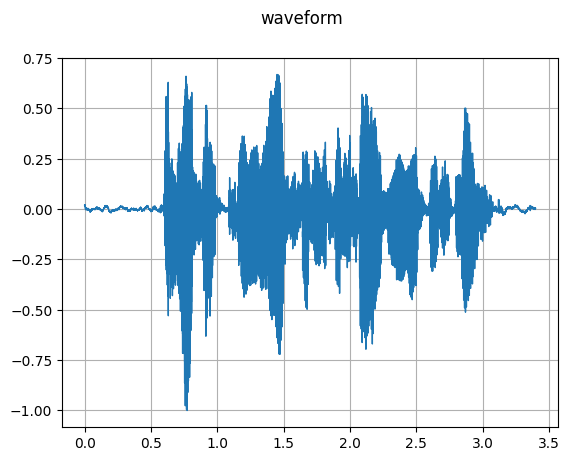

In [ ]:
plot_waveform(waveform, sample_rate)

In [ ]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)

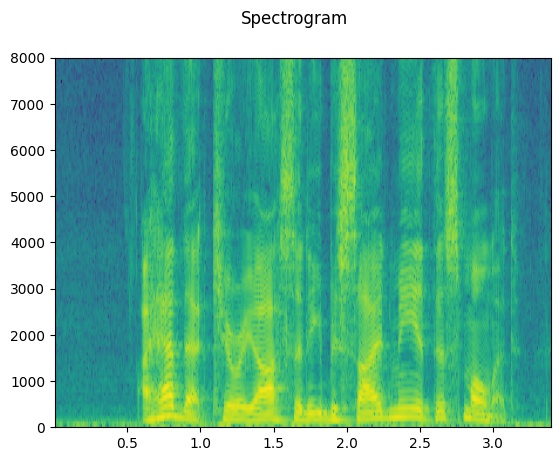

In [ ]:
plot_specgram(waveform, sample_rate)

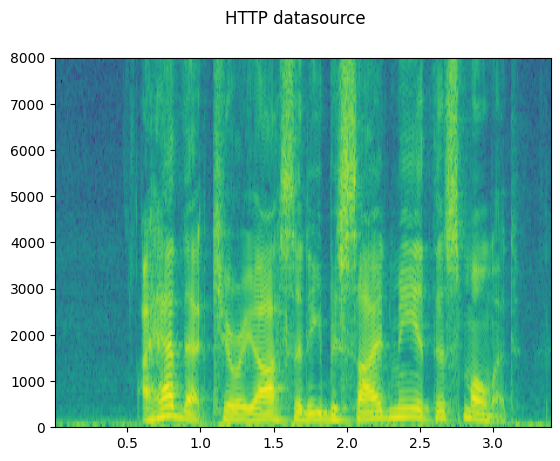

In [ ]:
# Load audio data as HTTP request
url = "https://download.pytorch.org/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
with requests.get(url, stream=True) as response:
    waveform, sample_rate = torchaudio.load(_hide_seek(response.raw))
plot_specgram(waveform, sample_rate, title="HTTP datasource")

/tmp/ipython-input-2384981077.py:2: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  tar_path = download_asset("tutorial-assets/VOiCES_devkit.tar.gz")
100%|██████████| 110k/110k [00:00<00:00, 2.01MB/s]


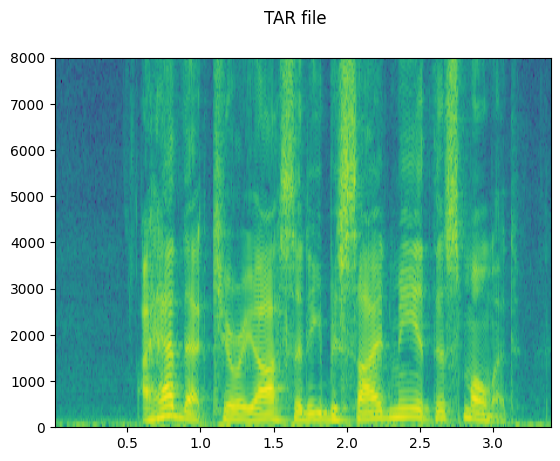

In [ ]:
# Load audio from tar file
tar_path = download_asset("tutorial-assets/VOiCES_devkit.tar.gz")
tar_item = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
with tarfile.open(tar_path, mode="r") as tarfile_:
    fileobj = tarfile_.extractfile(tar_item)
    waveform, sample_rate = torchaudio.load(fileobj)
plot_specgram(waveform, sample_rate, title="TAR file")

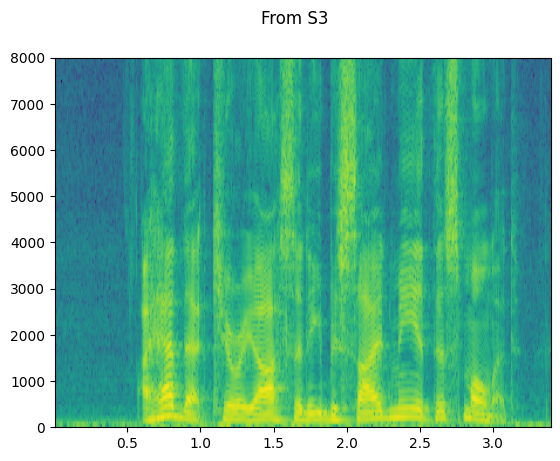

In [ ]:
# Load audio from S3
bucket = "pytorch-tutorial-assets"
key = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
client = boto3.client("s3", config=Config(signature_version=UNSIGNED))
response = client.get_object(Bucket=bucket, Key=key)
waveform, sample_rate = torchaudio.load(_hide_seek(response["Body"]))
plot_specgram(waveform, sample_rate, title="From S3")

In [ ]:
# Illustration of two different decoding methods.
# The first one will fetch all the data and decode them, while
# the second one will stop fetching data once it completes decoding.
# The resulting waveforms are identical.

frame_offset, num_frames = 16000, 16000  # Fetch and decode the 1 - 2 seconds

url = "https://download.pytorch.org/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
print("Fetching all the data...")
with requests.get(url, stream=True) as response:
    waveform1, sample_rate1 = torchaudio.load(_hide_seek(response.raw))
    waveform1 = waveform1[:, frame_offset : frame_offset + num_frames]
    print(f" - Fetched {response.raw.tell()} bytes")

print("Fetching until the requested frames are available...")
with requests.get(url, stream=True) as response:
    waveform2, sample_rate2 = torchaudio.load(
        _hide_seek(response.raw), frame_offset=frame_offset, num_frames=num_frames
    )
    print(f" - Fetched {response.raw.tell()} bytes")

print("Checking the resulting waveform ... ", end="")
assert (waveform1 == waveform2).all()
print("matched!")

Fetching all the data...
 - Fetched 108844 bytes
Fetching until the requested frames are available...
 - Fetched 108844 bytes
Checking the resulting waveform ... matched!


In [ ]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

In [ ]:
def inspect_file(path):
    print("-" * 10)
    print("Source:", path)
    print("-" * 10)
    print(f" - File size: {os.path.getsize(path)} bytes")
    print(f" - {torchaudio.info(path)}")
    print()

In [ ]:
with tempfile.TemporaryDirectory() as tempdir:
    path = f"{tempdir}/save_example_default.wav"
    torchaudio.save(path, waveform, sample_rate)
    inspect_file(path)

----------
Source: /tmp/tmp3ykvyo_m/save_example_default.wav
----------
 - File size: 108878 bytes
 - AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=16, encoding=PCM_S)



/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:337: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.save_with_torchcodec` under the hood. Some parameters like format, encoding, bits_per_sample, buffer_size, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's encoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.encoders.AudioEncoder
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:247: UserWarning: torio.io._streaming_media_encoder.StreamingMediaEncoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  s 

In [ ]:
with tempfile.TemporaryDirectory() as tempdir:
    path = f"{tempdir}/save_example_PCM_S16.wav"
    torchaudio.save(path, waveform, sample_rate, encoding="PCM_S", bits_per_sample=16)
    inspect_file(path)

----------
Source: /tmp/tmpvw7nwetx/save_example_PCM_S16.wav
----------
 - File size: 108878 bytes
 - AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=16, encoding=PCM_S)



/tmp/ipython-input-3348391189.py:6: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  print(f" - {torchaudio.info(path)}")


In [ ]:
formats = [
    "flac",
    # "vorbis",
    # "sph",
    # "amb",
    # "amr-nb",
    # "gsm",
]

In [ ]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV_8000)
with tempfile.TemporaryDirectory() as tempdir:
    for format in formats:
        path = f"{tempdir}/save_example.{format}"
        torchaudio.save(path, waveform, sample_rate, format=format)
        inspect_file(path)

----------
Source: /tmp/tmpv7esqgum/save_example.flac
----------
 - File size: 45264 bytes
 - AudioMetaData(sample_rate=8000, num_frames=27200, num_channels=1, bits_per_sample=16, encoding=FLAC)



/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

In [ ]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV_8000)
with tempfile.TemporaryDirectory() as tempdir:
    for format in formats:
        path = f"{tempdir}/save_example.{format}"
        torchaudio.save(path, waveform, sample_rate, format=format)
        inspect_file(path)

In [ ]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

# Saving to bytes buffer
buffer_ = io.BytesIO()
torchaudio.save(buffer_, waveform, sample_rate, format="wav")

buffer_.seek(0)
print(buffer_.read(16))

b'RIFFF\xa9\x01\x00WAVEfmt '


https://docs.pytorch.org/audio/stable/tutorials/audio_io_tutorial.html 이거 예제 따라한거임
